### Finding the maximum posterior

In this notebook, we will step through the same example that we examined in the lecture - estimating the mean of six data points using the maximum posterior method. We will also play with changing our prior, to see what difference it makes.

First the usual setup:

In [1]:
import numpy as np
from math import *
from scipy import stats 
import matplotlib.pyplot as plt

from bokeh.plotting import figure, output_file, output_notebook, show
output_notebook() 
from bokeh.models import Label

Loading BokehJS ...

Now set the input data, and also set up some other things we will need for plotting. To plot the data values, we set up a dummy "index" array that is just the data value number - value number 1, value number 2, and so on. To make the error bars, we have to make a "list of lists" to feed to multi_line in Bokeh. Don't worry if this bamboozles you - not one of the most user-friendly bits of Bokeh!

In [2]:
############ set input data to test
y=[256.0, 239.0, 237.0, 278.0, 266.0, 240.0] # define sample as a list of values
sig=16.0 # error on all points
################ now make some more needed things
N= len(y) # get the number of points in the sample.
index=np.arange(1,N+1)    # makes an array of the index numbers for the data values
# create the list of lists to use with multi-line in Bokeh
xlines=[]   # initialise a "list of lists"
ylines=[]
for i in range(0,N):
    xlines.append([i+1,i+1])
    ylines.append( [y[i]-sig,y[i]+sig] )
print(xlines)  # uncomment these to see what a list of lists looks like!
print(ylines)

[[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6]]
[[240.0, 272.0], [223.0, 255.0], [221.0, 253.0], [262.0, 294.0], [250.0, 282.0], [224.0, 256.0]]


#### Likelihood for single trial value of mu

As a first exercise, plot the data points, compare to a hypothesised trial value of the mean mu, and calculate the likelihood of the data points, assuming that value of mu. Note that we are assuming that the error on the data points represents the sigma of a Gaussian distribution. 

In [3]:
testmu=262.0   # set a trial value of mu

## calculate the joint likelihood for all points
# note we typically get tiny numbers
# which you can check by uncommenting the print statements
L=1.0 # initialise likelihood
for i in range(0,N):
#    print(L)
    L=L*stats.norm.pdf(y[i],testmu,sig) # multiply the joint L so far by the next L
#print("%.3g" %L)

p1 = figure(title="Test single mu", width=600, height=400,
x_axis_label='Data index number', y_axis_label='data value',
tools="pan,wheel_zoom,box_zoom,reset,hover,crosshair",x_range=(0,N+1), y_range=(190,320))

p1.circle(index,y,color="red", size=8.0)
p1.multi_line(xlines,ylines,color="red", width=2)
p1.line([0,N+1],[testmu,testmu],line_dash="dashed") # plot the trial mu value

# label plot
mulabel='test mu='+str(testmu)
Llabel='L='+str("%.3g"%L)

label1=Label(x=5, y=310,text=mulabel)
label2=Label(x=5, y=300,text=Llabel)

p1.add_layout(label1)
p1.add_layout(label2)

show(p1)


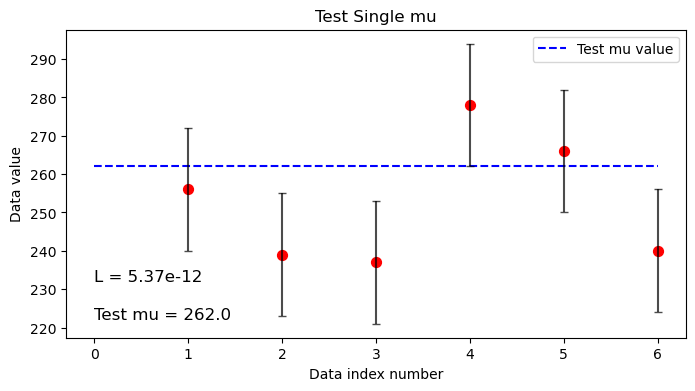

In [4]:

# Sample data and parameters
testmu = 262.0

# Calculate the joint likelihood for all points
L = 1.0  # Initialize likelihood
for i in range(N):
    L *= stats.norm.pdf(y[i], testmu, sig)

# Create Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Test Single mu")
ax.set_xlabel("Data index number")
ax.set_ylabel("Data value")

# Plot data points, lines, and the trial mu value using Matplotlib
ax.scatter(index, y, color="red", s=50)
ax.plot([0, N], [testmu, testmu], linestyle="dashed", color="blue", label="Test mu value")
ax.errorbar(index, y, yerr=sig, fmt='none', ecolor='black', capsize=3, capthick=1, linestyle="None", alpha=0.7)

# Add labels to the 3
mulabel = f'Test mu = {testmu}'
Llabel = f'L = {L:.3g}'
ax.text(0, 222, mulabel, fontsize=12)
ax.text(0, 232, Llabel, fontsize=12)

# Show legend
ax.legend()

# Show the Matplotlib plot
plt.show()


Try playing with different values of testmu and see how the likelihood changes

#### Plot the likelihood function

Now we can try looping over a whole range of trial $\mu$ values, and making a plot of the likelihood function $L(\mu)$

Maximum Likelihood: 253.0


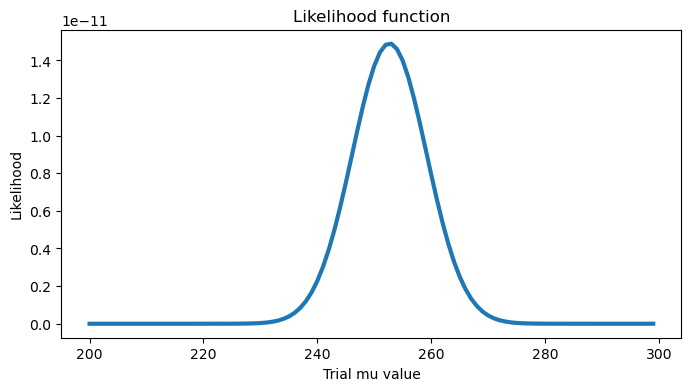

In [5]:
mustep = 1.0
mumin = 200.0
mumax = 300.0
muarray = np.arange(mumin, mumax, mustep)  # Set up array of trial mu values
Lmu = np.zeros(len(muarray))  # Initialize likelihood array

# Calculate the likelihood for all trial mu values
for i, mu in enumerate(muarray):
    L = 1.0
    for k in range(N):
        L *= stats.norm.pdf(y[k], mu, sig)
    Lmu[i] = L

# Find the position of the peak (maximum likelihood)
max_likelihood_index = np.argmax(Lmu)
max_likelihood_value = muarray[max_likelihood_index]
print("Maximum Likelihood:", max_likelihood_value)

# Create Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Likelihood function")
ax.set_xlabel("Trial mu value")
ax.set_ylabel("Likelihood")

# Plot likelihood function using Matplotlib
ax.plot(muarray, Lmu, linewidth=3)

# Show the Matplotlib plot
plt.show()

At this point, if we were using the maximum likelihood method, we could just use this to estimate our frequentist maximum likelihood value for $\mu$ by finding the peak of that curve. 

#### Becoming a Bayesian by Adding the prior 

Because we are looking at a continuous parameter $\mu$ over a range, we need a *prior function* $\pi(\mu)$. To avoid  we want this to a smooth function which peaks near  a reasonable value, and tails off gradually, but is not too informative. We will choose to set a Gaussian prior with a broad range, $\sigma^2=400$

In [6]:
#### Set parameters for a Gaussian prior and set the values
pimean=245.0
pisig=20.0
pimu=np.zeros(len(muarray)) # initialise prior fn
for i in range(0,len(muarray)):
    pimu[i]=stats.norm.pdf(muarray[i],pimean,pisig)
pimax=np.max(pimu)  # we will use this later to rescale L

We already have $L(\mu)$, so we can calculate the marginalised likelihood $E=\int{L(\mu)\pi(\mu) d\mu}$ and the posterior probability

$$ P(\mu) = \pi(\mu) \frac{L(\mu)}{E}$$

We can then plot the likelihood, the prior, and the posterior on top of each other for comparison. Note however that the prior and the posterior are normalised so that they integrate to 1.0, whereas the likelihood is not - its much smaller.
We could normalise it by calculating the Evidence, but its easier just to divide by the numerical integral (sum of the array) provided our array spans a wide enough range of $\mu$

Maximum Likelihood: 253.0
Maximum Posterior: 252.0


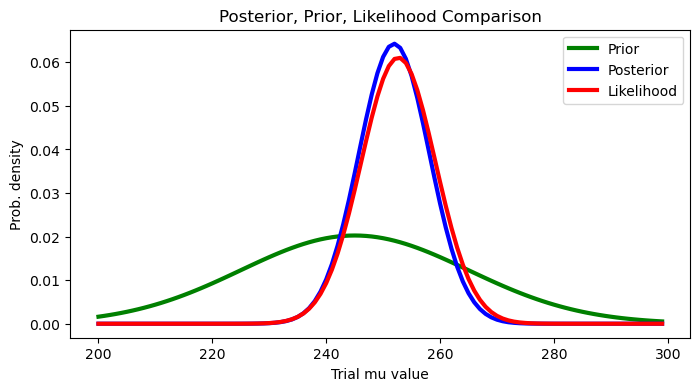

In [7]:
E=0.0 #initialise E
# integrate to get E
# note we can use the same mumin, mumax as the plot to do our numerical integration
for i in range(0,len(muarray)):
    E=E+Lmu[i]*pimu[i]*mustep

# now calculate the posterior
Pmu=np.zeros(len(muarray)) # initialise the posterior function
for i in range(0,len(muarray)):
    Pmu[i]=pimu[i]*Lmu[i]/E

# Print maximum likelihood and maximum posterior values
print("Maximum Likelihood:", muarray[np.argmax(Lmu)])
print("Maximum Posterior:", muarray[np.argmax(Pmu)])

# Create Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Posterior, Prior, Likelihood Comparison")
ax.set_xlabel("Trial mu value")
ax.set_ylabel("Prob. density")

# Plot prior, posterior, and likelihood functions using Matplotlib
ax.plot(muarray, pimu / np.sum(pimu), label="Prior", linewidth=3, color='green')
ax.plot(muarray, Pmu / np.sum(Pmu), label="Posterior", linewidth=3, color='blue')
ax.plot(muarray, Lmu / np.sum(Lmu), label="Likelihood", linewidth=3, color='red')

# Show legend
ax.legend()

# Show the Matplotlib plot
plt.show()


#### Explore

Try playing with the prior. If you set the prior to be fairly broad, and with a mean not too far from the maximum of the likelihood function, you will see that the posterior and the scaled likelihood are very little different. If you narrow the prior function, it makes more difference. If you set the mean of the prior to be a fair bit above or below the likelihood, you will see that the posterior ends up as a kind of compromise between what the data are telling you, and what your prior information is telling you.  With Gaussian prior and Gaussian likelihoods, we obtain a weighted mean of the two, with the *widths* determining the weighting.  With more data, the width of the likelihood gets narrower, so the posterior will favour the data.


#### Numerical estimates from $P(\mu)$

Because we think we have gone over a large enough range of $\mu$, the posterior $P(\mu)$ should be properly normalised. So we can also get any probability range we like graphically in quite a simple way, by deriving the cumulative version of $P(\mu)$


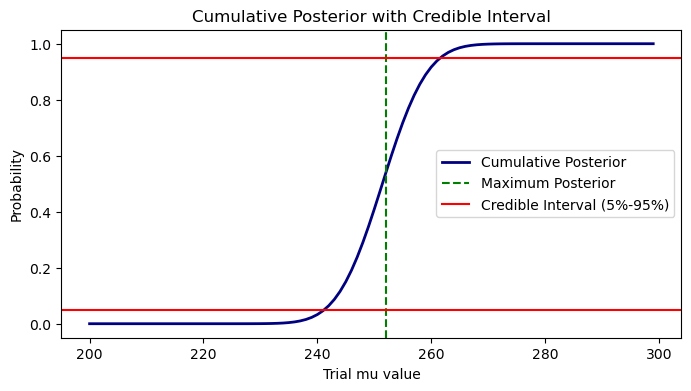

In [8]:
indexmax=np.argmax(Pmu)    # gives the array index where the value is max.
muest=mumin+indexmax*mustep # calculate the actual mu value where P is peak
Pcum=np.cumsum(Pmu) # get the cumultive version of P

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Cumulative Posterior with Credible Interval")
ax.set_xlabel("Trial mu value")
ax.set_ylabel("Probability")

# Plot cumulative posterior using Matplotlib
ax.plot(muarray, Pcum, linewidth=2, color='navy', label='Cumulative Posterior')
ax.axvline(x=muest, linestyle='dashed', color='green', label='Maximum Posterior')
ax.axhline(y=0.05, linestyle='solid', color='red', label='Credible Interval (5%-95%)')
ax.axhline(y=0.95, linestyle='solid', color='red')

# Show legend
ax.legend()
plt.show()



#### Explore

The vertical line marks the position where the posterior peaks. Try calculating the mean of our $N$ data points and see if we have the same answer!

You can get the integrated probability regions graphically to a good accuracy by zooming in and out on the plot and using the cursor. We have plotted horizontal lines at 5% and 95% integrated probability. Where do they cross the curve? Then the symmetrical 90% region is between those points.
